## Introduction

We are exploring two different questions:
1. What attributes are involved with schools that have CS programs vs schools that do not? This question will be tackled first.
2. For schools with CS, do any attributes of the individual student contribute to whether or not they take CS? This may be explored in a separate notebook. And the enrollment rate?

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
ospi_data = pd.read_csv('2022_school_pt5.csv',  index_col=0)

In [4]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,26,3,7,0,4,0,6,1,11,2
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,1086,140,382,51,328,44,321,29,250,45
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,57,16,18,9,15,2,14,1,13,5
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,107,14,32,5,35,3,25,3,21,7
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,142,0,16,0,51,0,41,0,59,0


In [5]:
len(ospi_data.index)

730

In [6]:
ospi_data['AllStudents'].sum()

390223

In [7]:
ospi_data = ospi_data.iloc[:,:-15]

In [8]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,0,2,0,24,3,0,0,28,3,17
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,0,3,0,98,17,402,54,879,115,1069
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,0,4,2,32,5,7,3,53,14,48
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,0,3,0,97,16,0,0,113,18,47
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,0,5,0,148,0,0,0,167,0,133


In [9]:
def low_inc_perc(row):
    return row['I_LowIncome'] / row['AllStudents']

ospi_data['PercentLowIncome'] = ospi_data.apply(low_inc_perc, axis=1)

In [10]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,PercentLowIncome
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,2,0,24,3,0,0,28,3,17,0.607143
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,3,0,98,17,402,54,879,115,1069,0.834504
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,4,2,32,5,7,3,53,14,48,0.800000
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,3,0,97,16,0,0,113,18,47,0.415929
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,5,0,148,0,0,0,167,0,133,0.796407


In [11]:
pd.set_option('display.max_columns', None)
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,PercentLowIncome
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,0.607143
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,646,109,0,0,0,0,5,1,2,0,1173,151,0,0,0,0,3,0,98,17,402,54,879,115,1069,0.834504
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,29,9,1,0,0,0,0,0,1,0,23,10,0,0,0,0,4,2,32,5,7,3,53,14,48,0.800000
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,56,9,0,0,2,2,2,0,0,0,9,0,0,0,0,0,3,0,97,16,0,0,113,18,47,0.415929
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,78,0,0,0,1,0,0,0,2,0,11,0,0,0,0,0,5,0,148,0,0,0,167,0,133,0.796407


For the following, note that BIPOC does not include Asian in this calculation. The following calculation includes all reported racial identities except for Asian and white.

In [12]:
def number_bipoc(row):
    return (row['R_Native'] + row['R_Black'] + row['R_Hisp_Lat'] + row['R_HPI'] + row['R_TwoOrMore'])

ospi_data['R_BIPOC'] = ospi_data.apply(number_bipoc, axis=1)

In [13]:
def bipoc_perc(row):
    return (row['R_BIPOC']) / row['AllStudents']

ospi_data['PercentBIPOC'] = ospi_data.apply(bipoc_perc, axis=1)

## Preprocessing: Percentage of District Low Income and BIPOC

In [14]:
ospi_data['DistrictNumSchools'] = ospi_data.groupby('DistrictCode')['SchoolCode'].transform('size')
ospi_data['DistrictSize'] = ospi_data.groupby('DistrictCode')['AllStudents'].transform('sum')
ospi_data['DistrictLowIncome'] = ospi_data.groupby('DistrictCode')['I_LowIncome'].transform('sum')
ospi_data['DistrictPctLowIncome'] = ospi_data['DistrictLowIncome']/ospi_data['DistrictSize']
ospi_data['DistrictBIPOC'] = ospi_data.groupby('DistrictCode')['R_BIPOC'].transform('sum')
ospi_data['DistrictPctBIPOC'] = ospi_data['DistrictBIPOC']/ospi_data['DistrictSize']

In [15]:
columns_to_analyze = ['DistrictCode','SchoolCode','SchoolName','Longitude'
                      ,'Latitude','County','AllStudents','C_AllStudents', 'I_LowIncome', 'PercentLowIncome'
                      , 'R_BIPOC' ,'PercentBIPOC','DistrictNumSchools','DistrictSize','DistrictLowIncome','DistrictPctLowIncome'
                      ,'DistrictBIPOC','DistrictPctBIPOC']

reduced_ospi = ospi_data[columns_to_analyze]

In [16]:
reduced_ospi.head(25)

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687
6,2420,2434,Asotin Jr Sr High,-117.048210,46.339330,Asotin,177,0,62,0.350282,26,0.146893,1,177,62,0.350282,26,0.146893
7,3017,1884,Legacy High School,-119.184062,46.199694,Benton,716,0,334,0.466480,391,0.546089,8,7166,3615,0.504466,3355,0.468183
8,3017,2826,Kennewick High School,-119.126476,46.206332,Benton,1911,203,1249,0.653585,1101,0.576138,8,7166,3615,0.504466,3355,0.468183
9,3017,3731,Kamiakin High School,-119.187120,46.216464,Benton,2007,139,792,0.394619,770,0.383657,8,7166,3615,0.504466,3355,0.468183


## Preprocessing: Hot One Encoding
*Hot one encoding whether or not a school offers CS*  

In [17]:
reduced_ospi = reduced_ospi.copy()
reduced_ospi['CS_Offered'] = np.where(reduced_ospi['C_AllStudents'] == 0, 0, 1)
reduced_ospi.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0


## Preprocessing: Percentage of District with CS

In [18]:
reduced_ospi['DistrictCS'] = reduced_ospi.groupby('DistrictCode')['CS_Offered'].transform('sum')
reduced_ospi['DistrictPctCS'] = reduced_ospi['DistrictCS']/reduced_ospi['DistrictNumSchools']
reduced_ospi.head(25)

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0,2,0.500000
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687,1,2,0.500000
6,2420,2434,Asotin Jr Sr High,-117.048210,46.339330,Asotin,177,0,62,0.350282,26,0.146893,1,177,62,0.350282,26,0.146893,0,0,0.000000
7,3017,1884,Legacy High School,-119.184062,46.199694,Benton,716,0,334,0.466480,391,0.546089,8,7166,3615,0.504466,3355,0.468183,0,4,0.500000
8,3017,2826,Kennewick High School,-119.126476,46.206332,Benton,1911,203,1249,0.653585,1101,0.576138,8,7166,3615,0.504466,3355,0.468183,1,4,0.500000
9,3017,3731,Kamiakin High School,-119.187120,46.216464,Benton,2007,139,792,0.394619,770,0.383657,8,7166,3615,0.504466,3355,0.468183,1,4,0.500000


Quick sanity check for DistrictPctCS:

In [19]:
reduced_ospi[reduced_ospi['DistrictCode'] == 2250]

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0,2,0.5
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687,1,2,0.5
616,2250,5413,Educational Opportunity Center Reengagement,-117.057521,46.411019,Asotin,10,0,7,0.700000,2,0.200000,4,1034,559,0.540619,192,0.185687,0,2,0.5
701,2250,5644,Clarkston Home Alliance,-117.225934,46.369711,Asotin,54,4,30,0.555556,8,0.148148,4,1034,559,0.540619,192,0.185687,1,2,0.5


In [20]:
reduced_ospi[reduced_ospi['DistrictCode'] == 3116]

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
15,3116,2508,Prosser High School,-119.767241,46.203649,Benton,972,2,683,0.702675,650,0.668724,2,1011,716,0.70821,676,0.668645,1,1,0.5
658,3116,5537,Prosser Opportunity Academy,-119.767241,46.203649,Benton,39,0,33,0.846154,26,0.666667,2,1011,716,0.70821,676,0.668645,0,1,0.5


## Preprocessing: Adding County Population

In [21]:
census_df = pd.read_csv('co-est2023-alldata.csv',  index_col=0, encoding = 'latin')
wa_counties = census_df.loc[census_df['STNAME'] == 'Washington'].copy(deep=True)
wa_pop = wa_counties.loc[:, ('POPESTIMATE2023', 'CTYNAME')]
wa_pop = wa_pop[((wa_pop.CTYNAME != 'Washington'))].copy(deep=True)

In [22]:
def remove_county(row):
    return row['CTYNAME'][:-7]

wa_pop['County'] = wa_pop.apply(remove_county, axis=1)

In [23]:
wa_pop = wa_pop.loc[:, ('POPESTIMATE2023', 'County')]
reduced_ospi = pd.merge(wa_pop, reduced_ospi, how='outer', on='County')

In [24]:
reduced_ospi = reduced_ospi.rename(columns={"POPESTIMATE2023": "CountyPop"})

In [25]:
reduced_ospi.head()

,CountyPop,County,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
0,20820,Adams,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000
1,20820,Adams,1147,3015,Othello High School,-119.165246,46.822710,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333
2,20820,Adams,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000
3,20820,Adams,1160,2132,Ritzville High School,-118.292516,47.125588,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000
4,20820,Adams,1147,5367,Desert Oasis High School,-119.163036,46.818533,142,0,131,0.922535,130,0.915493,3,1464,1235,0.843579,1346,0.919399,0,1,0.333333


## Preprocessing: Using Longitude and Latitude

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
geo_df_scaled = scaler.fit_transform(reduced_ospi[['Longitude', 'Latitude']])


In [27]:
from sklearn.cluster import KMeans

# Set the number of zones--starting with five for now
num_clusters = 10 
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
reduced_ospi['CountyZone'] = kmeans.fit_predict(geo_df_scaled)


/Users/ebrink/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [84]:
# import matplotlib.pyplot as plt

# plt.scatter(reduced_ospi['Longitude'], reduced_ospi['Latitude'], c=reduced_ospi['CountyZone'], cmap='10tab')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Geospatial Clustering with K-Means')
# plt.show()


### Ideas for how to meaningful encode zones:
* Population
* Population density (possible to do this for counties, too?)
* Socioeconomic features similar to percent low income, etc for schools and districts
* 

## Preprocessing: Binning

*Random forest and gradient boosting machines will benefit from binning.*

(School income from original), Bands:  <20%, 20 – 40%, 40% - 60%, 60% - 80%, 80%+

(School size modified from original): <=100, 101 – 300, 301 – 900. 901 – 1800. 1801+

(Disadvantaged race/ethnic percentage): < 15%, 15% - 30%, 30% - 50%, 50% - 75%, 75%+

(Location):  (King),  (Pierce, Snohomish, Spokane, Clark), (All Others). 

In [50]:
income_bins = [-float('inf'), .20, .40, .60, .80, float('inf')]
income_labels = ['1', '2', '3', '4', '5']

size_bins = [-float('inf'), 100, 300, 900, 1800, float('inf')]
size_labels = ['1', '2', '3', '4', '5']

bipoc_bins = [-float('inf'), .15, .30, .50, .75, float('inf')]
bipoc_labels = ['1', '2', '3', '4', '5']

reduced_ospi['IncomeBinned'] = pd.cut(ospi_data['PercentLowIncome'], bins=income_bins, labels=income_labels)
reduced_ospi['SchoolSizeBinned'] = pd.cut(ospi_data['AllStudents'], bins=size_bins, labels=size_labels)
reduced_ospi['BIPOCBinned'] = pd.cut(ospi_data['PercentBIPOC'], bins=bipoc_bins, labels=bipoc_labels)

## Preprocessing: Adding median household income by county feature
This data is pulled from https://ofm.wa.gov/washington-data-research/economy-and-labor-force/median-household-income-estimates

2023 is a projection, all others are estimates

In [51]:
median_income = pd.read_csv('median_income.csv')

In [52]:
median_income.head()

,Unnamed: 0,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Washington,"31,183","33,417","34,379","35,882","36,679","37,895","38,997","40,568","42,399","44,514","45,776","44,120","45,761","46,039","46,967","49,585","50,004","53,522","56,141","57,858","55,458","54,888","55,500","56,444","57,284","60,153","63,439","65,500","69,288","72,297","78,674","80,319","84,155","91,255","94,308"
1,Adams,"24,604","28,024","27,301","28,328","31,277","29,537","29,604","31,806","31,795","34,073","33,888","35,292","37,839","38,306","38,934","39,235","39,105","41,298","42,299","42,455","41,102","40,656","41,068","42,354","43,541","45,712","47,646","49,501","48,849","52,870","53,535","56,421","57,405","62,410","64,498"
2,Asotin,"22,897","24,206","25,110","26,251","27,359","27,873","28,288","29,813","31,499","32,477","33,524","32,590","35,920","37,013","37,080","37,140","37,657","39,768","40,558","42,945","40,035","39,820","40,171","41,703","42,174","43,368","46,107","47,020","51,767","50,746","54,776","53,377","56,438","65,625","67,820"
3,Benton,"32,593","35,012","37,093","39,228","41,153","42,790","42,540","42,817","44,057","45,665","47,044","49,389","52,598","53,736","55,409","57,613","56,200","54,942","55,361","57,114","58,496","60,070","60,608","62,739","63,710","63,157","62,071","62,282","63,502","67,912","72,847","75,882","77,339","85,144","87,992"
4,Chelan,"24,312","25,833","27,592","28,746","30,148","31,547","32,164","33,918","35,662","37,175","37,316","39,439","41,653","41,731","42,918","43,696","44,422","46,522","44,964","44,013","46,780","45,478","46,275","47,265","51,713","50,825","53,068","55,109","60,791","60,747","59,838","61,546","64,700","81,697","84,430"


In [53]:
median_income.columns

Index(['Unnamed: 0', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'],
      dtype='object')

In [54]:
income = median_income[['Unnamed: 0','2022']]

In [55]:
income.columns = ['County','MedianIncome']

In [56]:
income.loc[:,'MedianIncome'] = income.loc[:,'MedianIncome'].str.strip()

In [57]:
income.loc[:,'MedianIncome'] = income.loc[:,'MedianIncome'].str.replace(',', '').astype(float)

In [58]:
income.dtypes

County          object
MedianIncome    object
dtype: object

In [59]:
with_income = pd.merge(reduced_ospi, income, on='County')

In [60]:
with_income.head()

,CountyPop,County,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS,CountyZone,IncomeBinned,SchoolSizeBinned,BIPOCBinned,MedianIncome
0,20820,Adams,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000,4,4,1,1,62410.0
1,20820,Adams,1147,3015,Othello High School,-119.165246,46.822710,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333,4,5,4,5,62410.0
2,20820,Adams,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000,3,4,1,3,62410.0
3,20820,Adams,1160,2132,Ritzville High School,-118.292516,47.125588,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000,3,3,2,1,62410.0
4,20820,Adams,1147,5367,Desert Oasis High School,-119.163036,46.818533,142,0,131,0.922535,130,0.915493,3,1464,1235,0.843579,1346,0.919399,0,1,0.333333,4,4,2,1,62410.0


In [40]:
reduced_ospi['IncomeBinned'].value_counts()

IncomeBinned
3    225
4    197
2    170
5     73
1     65
Name: count, dtype: int64

In [41]:
reduced_ospi['SchoolSizeBinned'].value_counts()

SchoolSizeBinned
1    253
2    176
4    125
3    124
5     52
Name: count, dtype: int64

In [42]:
reduced_ospi['BIPOCBinned'].value_counts()

BIPOCBinned
3    247
2    236
4    131
5     60
1     56
Name: count, dtype: int64

## Preprocessing: Preparing for tree-based algorithms
*Because tree based algorithms are not sensitive to feature scaling.*

In [44]:
## First version, using all available features without further feature engineering
df_for_tree = reduced_ospi.loc[:, ('CountyPop','Longitude', 'Latitude','DistrictNumSchools','DistrictSize','CS_Offered','IncomeBinned','SchoolSizeBinned','BIPOCBinned')]

In [45]:
df_for_tree.head()

,CountyPop,Longitude,Latitude,DistrictNumSchools,DistrictSize,CS_Offered,IncomeBinned,SchoolSizeBinned,BIPOCBinned
0,20820,-118.311231,46.752189,1,28,1,4,1,1
1,20820,-119.165246,46.822710,3,1464,1,5,4,5
2,20820,-118.292516,47.125588,1,60,1,4,1,3
3,20820,-118.292516,47.125588,1,113,1,3,2,1
4,20820,-119.163036,46.818533,3,1464,0,4,2,1


In [46]:
## First version, using all available features without further feature engineering
df_for_tree_v2 = reduced_ospi.loc[:, ('CountyPop','CountyZone','DistrictNumSchools','DistrictSize','CS_Offered','IncomeBinned','SchoolSizeBinned','BIPOCBinned')]

In [47]:
df_for_tree_v2.head()

,CountyPop,CountyZone,DistrictNumSchools,DistrictSize,CS_Offered,IncomeBinned,SchoolSizeBinned,BIPOCBinned
0,20820,4,1,28,1,4,1,1
1,20820,4,3,1464,1,5,4,5
2,20820,3,1,60,1,4,1,3
3,20820,3,1,113,1,3,2,1
4,20820,4,3,1464,0,4,2,1


In [49]:
with_income.head()

,CountyPop,County,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS,CountyZone,MedianIncome
0,20820,Adams,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000,4,62410.0
1,20820,Adams,1147,3015,Othello High School,-119.165246,46.822710,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333,4,62410.0
2,20820,Adams,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000,3,62410.0
3,20820,Adams,1160,2132,Ritzville High School,-118.292516,47.125588,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000,3,62410.0
4,20820,Adams,1147,5367,Desert Oasis High School,-119.163036,46.818533,142,0,131,0.922535,130,0.915493,3,1464,1235,0.843579,1346,0.919399,0,1,0.333333,4,62410.0


In [61]:
## With median household income by county added
df_for_tree_v3 = with_income.loc[:, ('CountyPop','CountyZone','DistrictNumSchools','DistrictSize','CS_Offered','IncomeBinned','SchoolSizeBinned','BIPOCBinned','MedianIncome')]

In [62]:
df_for_tree_v3.head()

,CountyPop,CountyZone,DistrictNumSchools,DistrictSize,CS_Offered,IncomeBinned,SchoolSizeBinned,BIPOCBinned,MedianIncome
0,20820,4,1,28,1,4,1,1,62410.0
1,20820,4,3,1464,1,5,4,5,62410.0
2,20820,3,1,60,1,4,1,3,62410.0
3,20820,3,1,113,1,3,2,1,62410.0
4,20820,4,3,1464,0,4,2,1,62410.0


## Preprocessing: Normalizing
*K-Nearest Neighbors and K-means Clustering will benefit from normalizing.*

## Preprocessing: Standardizing
*Linear regression, logistic regression and principal component analysis will benefit from standardizing.*

In [88]:
from sklearn.preprocessing import StandardScaler



X = with_income.loc[:, ('CountyPop','CountyZone','DistrictNumSchools','DistrictSize','IncomeBinned','SchoolSizeBinned','BIPOCBinned','MedianIncome')]
y = with_income['CS_Offered']

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

## Preprocessing: Class Weights

In [63]:
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', np.unique(y_train),y_train)

## Analysis: Random Forest

In [64]:
X = df_for_tree.drop(['CS_Offered'], axis = 1)
y = df_for_tree['CS_Offered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [65]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17d3aa710>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17d3a8350>})

In [66]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 415}


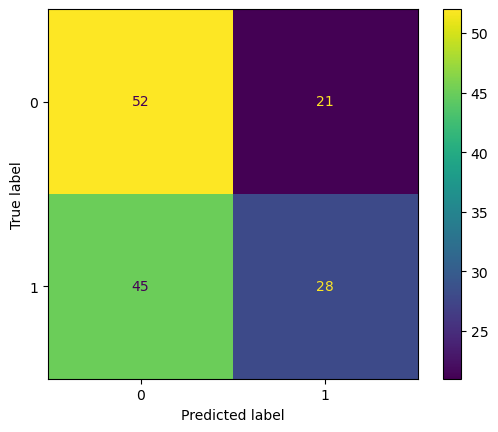

In [67]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [68]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.547945205479452
Precision: 0.5714285714285714
Recall: 0.3835616438356164


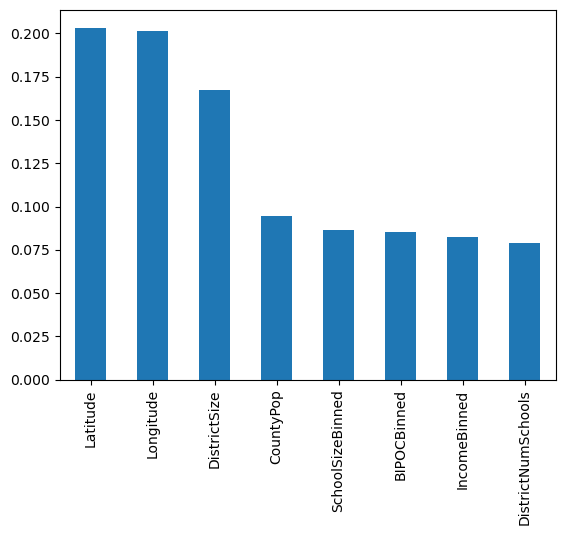

In [69]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

It appears that SchoolSizeBinned (size of school) and DistrictPctCS (percentage of district that offers CS) are the features with the most importance. 

Best hyperparameters: {'max_depth': 9, 'n_estimators': 183}


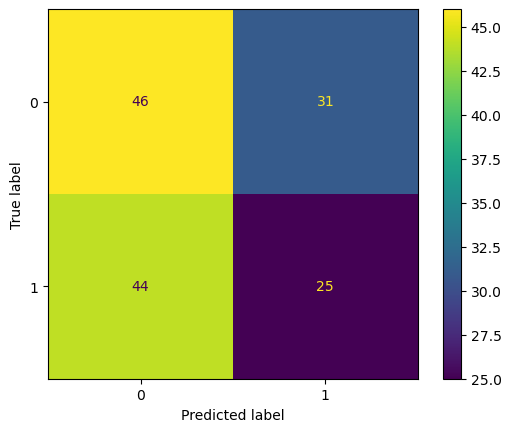

In [70]:
X = df_for_tree_v2.drop(['CS_Offered'], axis = 1)
y = df_for_tree_v2['CS_Offered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [71]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.4863013698630137
Precision: 0.44642857142857145
Recall: 0.36231884057971014


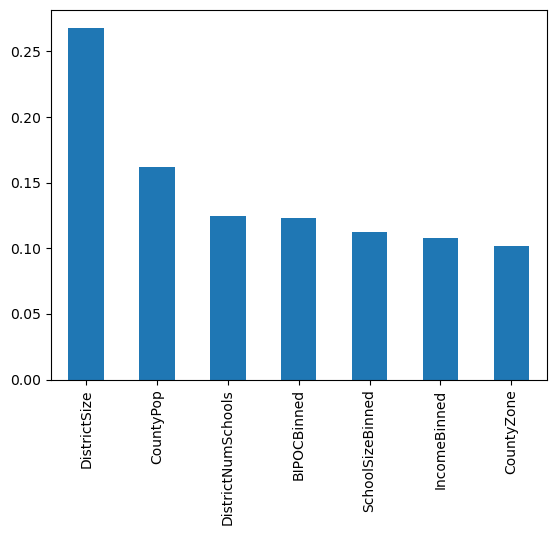

In [72]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

The CountyZone feature does appear to increase recall but doesn't positively affect accuracy or precision and lowers the importance of the location feature. The CountyZone feature may prove more useful in other models. SchoolSizeBinned appears to be the most important feature, regardless of how we handle the geographical data. 

Best hyperparameters: {'max_depth': 5, 'n_estimators': 117}


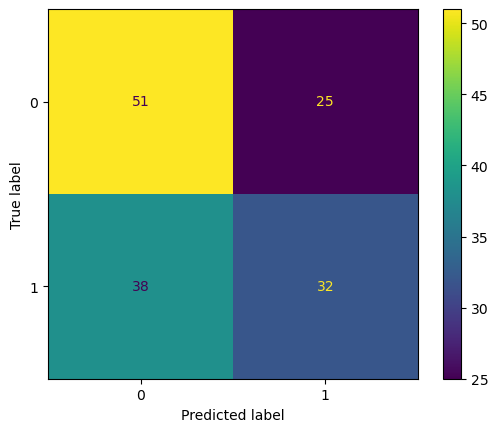

In [73]:
X = df_for_tree_v3.drop(['CS_Offered'], axis = 1)
y = df_for_tree_v3['CS_Offered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)


from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [74]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5684931506849316
Precision: 0.5614035087719298
Recall: 0.45714285714285713


## Analysis: Logistic Regression
### Correlation Heatmap
*To ensure there is not multicollinearity with our independent variables*

In [75]:
df_logistic_reg = reduced_ospi.loc[:, ('CountyPop','Longitude', 'Latitude','DistrictSize','CS_Offered','IncomeBinned','SchoolSizeBinned','BIPOCBinned')]

In [76]:
df_logistic_reg.dtypes

CountyPop              int64
Longitude            float64
Latitude             float64
DistrictSize           int64
CS_Offered             int64
IncomeBinned        category
SchoolSizeBinned    category
BIPOCBinned         category
dtype: object

In [77]:
df_logistic_reg['IncomeBinned'] = df_logistic_reg['IncomeBinned'].cat.codes
df_logistic_reg['SchoolSizeBinned'] = df_logistic_reg['SchoolSizeBinned'].cat.codes
df_logistic_reg['BIPOCBinned'] = df_logistic_reg['BIPOCBinned'].cat.codes


In [78]:
df_logistic_reg.dtypes

CountyPop             int64
Longitude           float64
Latitude            float64
DistrictSize          int64
CS_Offered            int64
IncomeBinned           int8
SchoolSizeBinned       int8
BIPOCBinned            int8
dtype: object

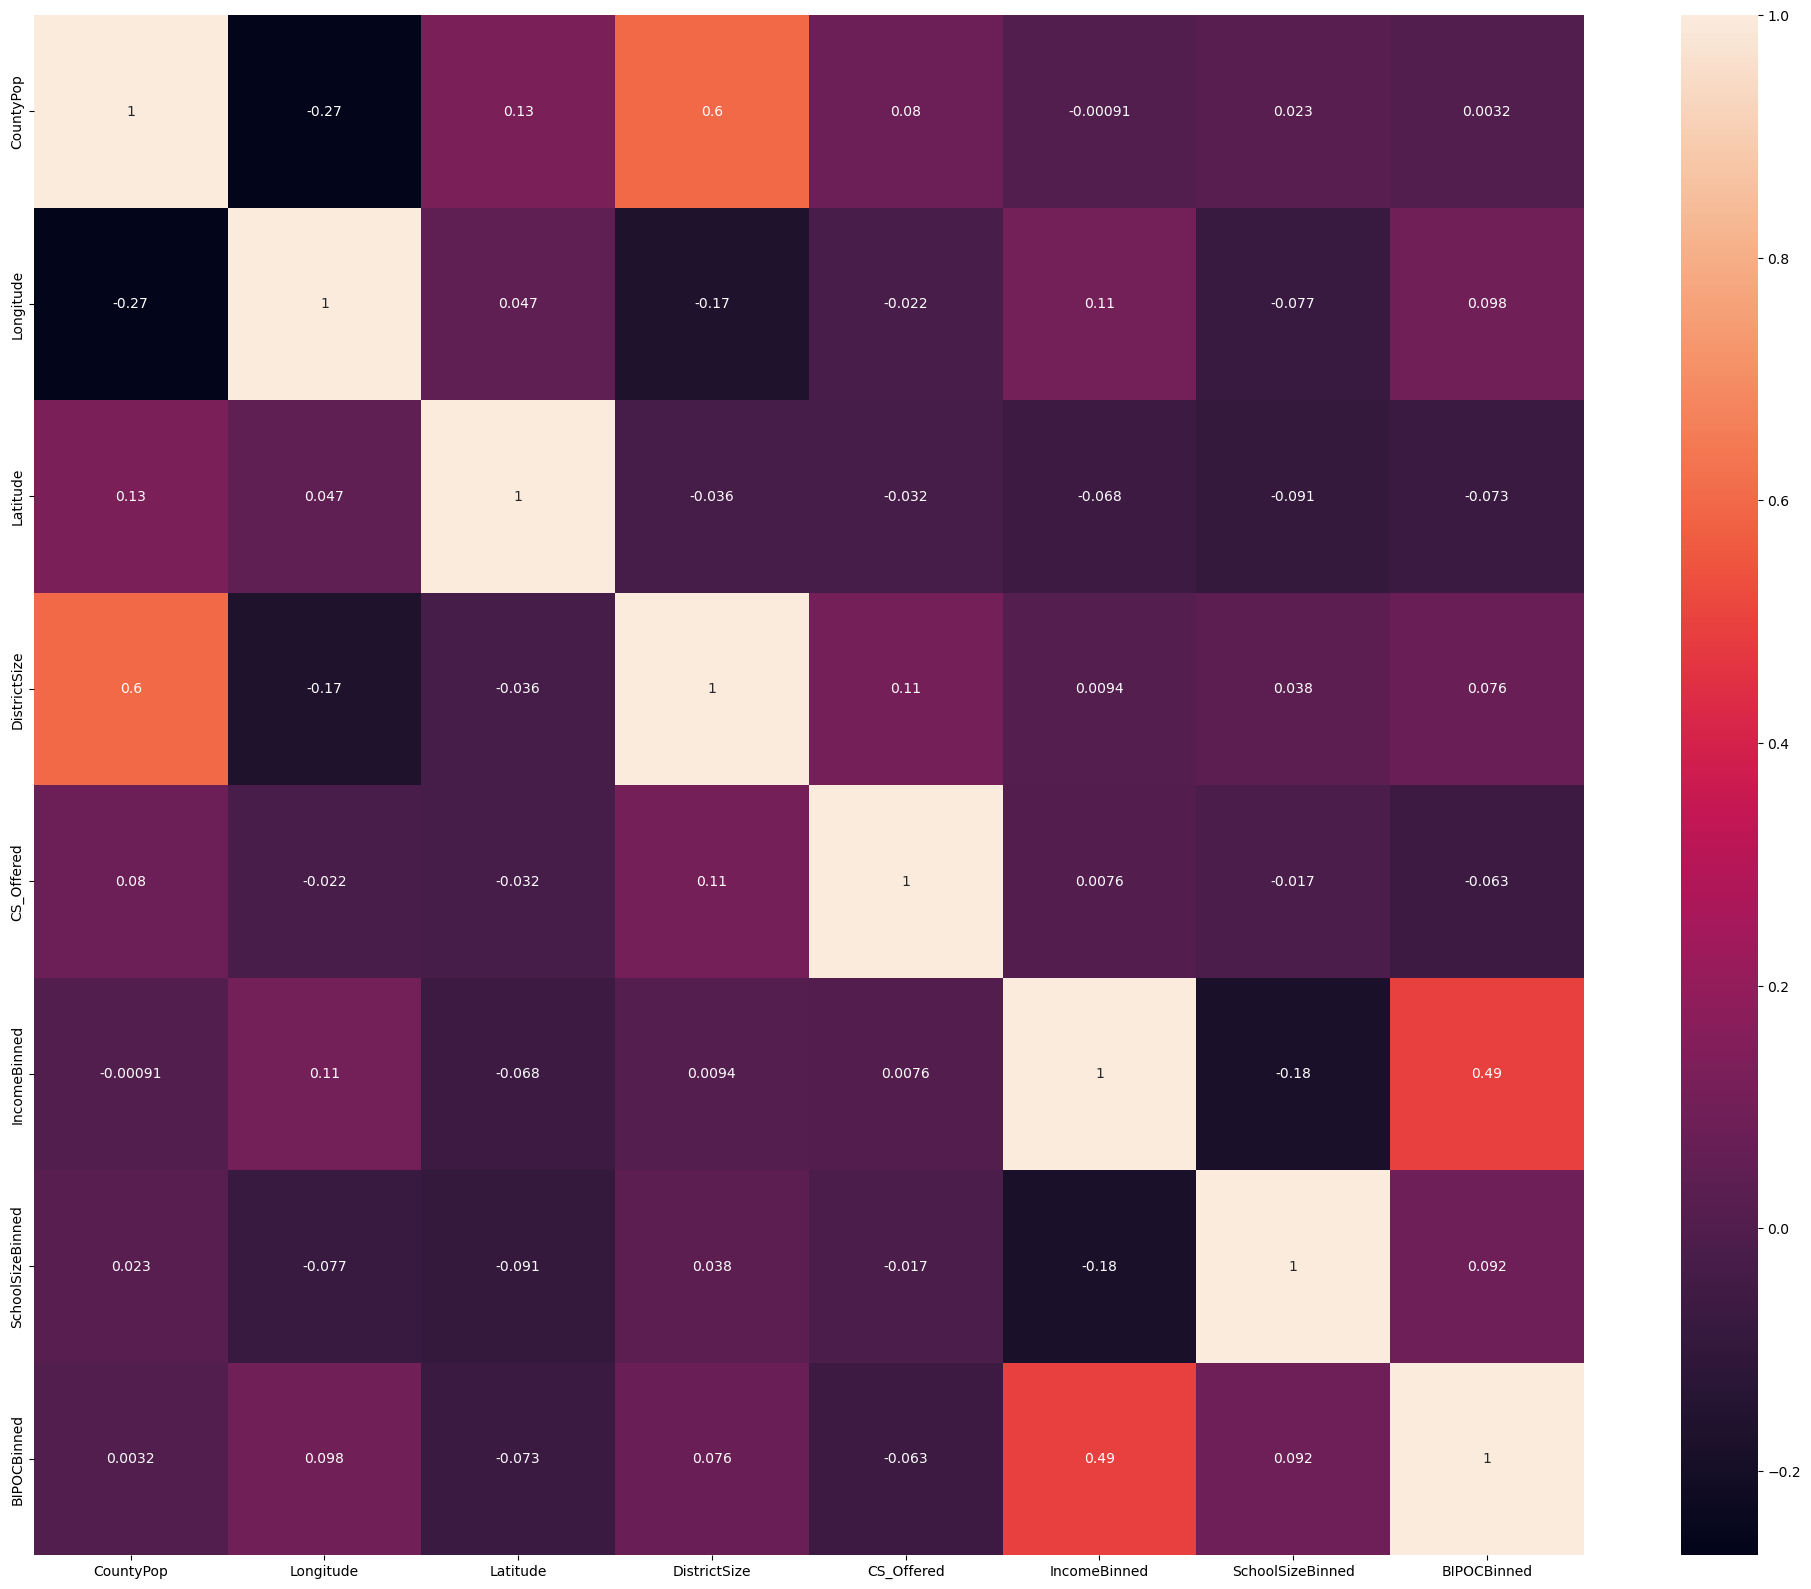

In [79]:
fig = plt.figure(figsize=(25, 20))
sns.heatmap(df_logistic_reg.corr(), annot=True)
plt.savefig("Heatmap.png")

None of these features have high correlation (over .7) with one another, so we can continue this analysis. Keeping in mind that the sample size may not be large enough to yield significant results.

In [80]:
X = df_logistic_reg.drop(['CS_Offered'], axis = 1)
y = df_logistic_reg['CS_Offered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [81]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.54


In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[88 31]
 [69 31]]


The inaccuracy here may be due to the insufficient amount of data. This may also be an opportunity for oversampling.

In [83]:
df_logistic_reg['CS_Offered'].sum()/df_logistic_reg.shape[0]

0.46301369863013697

## Analysis: PCA  

In [ ]:
X_scaled

## Analysis: Mutual Information

## Analysis: Ensemble Learning
TODO: Re-run after feature encoding above  
This is a very basic first run at ensemble learning...will improve

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statistics as st
import warnings
warnings.filterwarnings('ignore')

# SPLITTING THE DATASET
df = reduced_ospi
x = df.drop(['CS_Offered', 'SchoolName', 'County'], axis = 1)
y = df['CS_Offered']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# MODELS CREATION
model1 = RandomForestClassifier()
model2 = KNeighborsClassifier()
model3= LogisticRegression()

model1.fit(x_train,y_train)
model2.fit(x_train,y_train)
model3.fit(x_train,y_train)

# PREDICTION
pred1=model1.predict(x_test)
pred2=model2.predict(x_test)
pred3=model3.predict(x_test)

# FINAL_PREDICTION
final_pred = np.array([])
for i in range(0,len(x_test)):
    final_pred = np.append(final_pred, st.mode([pred1[i], pred2[i], pred3[i]]))
print(final_pred)